# HSKA AI-Lab RL: Deep Q-Network (DQN)

## Mount Google Drive as folder

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/My\ Drive/ai-lab

Wie in Aufgabe 3 soll nun DQN anhand von [Atari Pong](https://www.gymlibrary.ml/environments/atari/pong/) implementiert werden. Pong zählt zu den klassischen Atari 2600 Spielen und wird hier nahezu unverändert genutzt. Für Details siehe das [Paper von DeepMind](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

### Atari Pong Environment vorbereiten

In [2]:
%pip install --upgrade pip
%pip install gym==0.21.0
%pip install 'gym[atari]==0.12.5'
%pip install pyglet==1.3.2
%pip install pyvirtualdisplay
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:

import gym

import random
from collections import deque
from typing import Tuple
import time
from datetime import datetime
from contextlib import suppress

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense, Lambda, multiply, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.compat.v1.losses import huber_loss
from tensorflow.compat.v1.keras.backend import set_session
from loggers import TensorBoardLogger, tf_summary_image

import matplotlib.pyplot as plt
%matplotlib inline

from plot_utils import plot_statistics
from abstract_agent import AbstractAgent
from atari_helpers import LazyFrames, wrap_deepmind, make_atari

!apt-get install -y xvfb python-opengl

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
    from IPython.display import SVG

plt.ion()

2022-12-30 10:41:41.426559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
zsh:1: command not found: apt-get


In [4]:
env = make_atari('PongNoFrameskip-v0')
env = wrap_deepmind(env, frame_stack=True)

NoopResetEnv (max 30) wrapper is used.
MaxAndSkipEnv (skip 4) wrapper is used.
EpisodicLifeEnv wrapper is used.
FireResetEnv wrapper is used.
ClipRewardEnv wrapper is used.
FrameStack (4) wrapper is used.


### Aufgabe 4: DQN mit Atari Pong

Auch hier soll wieder der `DQNAgent` mit den Methoden `act`, `train` und `_replay` implementiert werden. Das entsprechende Model (siehe `_build_model`) ist dabei wie zuvor bereits vorgegeben. Im Unterschied zur Aufgabe 3 gibt es hier drei zusätzliche Layer bei denen Faltungen vorgenommen werden, um Pixel-basierte Stace-Spaces verarbeiten zu können. Diese Layer sitzen vor den vollverknüpften Layern, um dann anhand der in den Filter detektierten Features globale Entscheidungen treffen zu können.

In [8]:
class DQNAgent(AbstractAgent):

    def __init__(self, action_size: int, state_size: int,
                 gamma: float, epsilon: float, epsilon_decay: float, epsilon_min: float, 
                 alpha: float, batch_size: int, memory_size: int, start_replay_step: int, 
                 target_model_update_interval: int, train_freq: int):
        self.action_size = action_size
        self.state_size = state_size

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha

        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        self.step = 0
        self.start_replay_step = start_replay_step

        self.target_model_update_interval = target_model_update_interval
        self.train_freq = train_freq # Frequency (interval) at which model should be trained (steps)

        assert self.start_replay_step >= self.batch_size, \
            "The number of steps to start replay must be at least as large as the batch size"

        self.action_mask = np.ones((1, self.action_size))
        self.action_mask_batch = np.ones((self.batch_size, self.action_size))

        config = tf.compat.v1.ConfigProto(
            intra_op_parallelism_threads=8,
            inter_op_parallelism_threads=4,
            allow_soft_placement=True,
        )
        config.gpu_options.allow_growth = True
        session = tf.compat.v1.Session(config=config)
        set_session(session)  # set this TensorFlow session as the default session for Keras

        self.model = self._build_model()
        self.target_model = self._build_model()

    def _build_model(self):
        """Deep Q-network as defined in the DeepMind article on Nature
        
        Returns:
            model [Model]
        """
        atari_shape = (84, 84, 4)
        # With the functional API we need to define the inputs.
        # Sequential API no longer works because of merge mask
        frames_input = Input(atari_shape, name='frames')
        action_mask = Input((self.action_size,), name='action_mask')

        # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1]
        normalized = Lambda(lambda x: x / 255.0, name='normalization')(frames_input)

        # "The first hidden layer convolves 16 8×8 filters with stride 4 with the 
        # input image and applies a rectifier nonlinearity."
        conv1 = Conv2D(filters=16,
                       kernel_size=(8, 8),
                       strides=(4, 4),
                       activation='relu')(normalized)

        # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed 
        # by a rectifier nonlinearity."
        conv2 = Conv2D(filters=32,
                       kernel_size=(4, 4),
                       strides=(2, 2),
                       activation='relu')(conv1)

        # Flattening the last convolutional layer.
        conv_flattened = Flatten()(conv2)

        # "The final hidden layer is fully-connected and consists of 256 rectifier units."
        hidden = Dense(units=256, activation='relu')(conv_flattened)

        # "The output layer is a fully-connected linear layer with a single output 
        # for each valid action."
        output = Dense(self.action_size)(hidden)

        filtered_output = multiply([output, action_mask])

        model = Model(inputs=[frames_input, action_mask], outputs=filtered_output)
        model.compile(loss=huber_loss, optimizer=Adam(learning_rate=self.alpha), metrics=None)

        return model

    def _replay(self) -> None:
        """Gets random experiences from memory for batch update of Q-function.
        
        Returns:
            None
        """
        # TODO: Get a random mini-batch from memory and create numpy arrays for each part of this experience
        states, actions, next_states, rewards, dones = [np.array(memory) for memory in zip(*random.sample(self.memory, self.batch_size))]
        

        # TODO: Convert the parts of the mini-batch into corresponding numpy arrays.
        # Note that the states are of type 'LazyFrames' due to memory efficiency
        # and must therefore be converted individually
        #states = None
        #next_states = None
        #actions = None
        #rewards = None
        #dones = None

        # The following assert statements are intended to support further implementation,
        # but can also be removed/adjusted if necessary
        assert all(isinstance(x, np.ndarray) for x in (states, actions, rewards, next_states, dones)), \
            "All experience batches should be of type np.ndarray."
        assert states.shape == (self.batch_size, 84, 84, 4), \
            f"States shape should be: {(self.batch_size, 84, 84, 4)}"
        assert actions.shape == (self.batch_size,), f"Actions shape should be: {(self.batch_size,)}"
        assert rewards.shape == (self.batch_size,), f"Rewards shape should be: {(self.batch_size,)}"
        assert next_states.shape == (self.batch_size, 84, 84, 4), \
            f"Next states shape should be: {(self.batch_size, 84, 84, 4)}"
        assert dones.shape == (self.batch_size,), f"Dones shape should be: {(self.batch_size,)}"

        # TODO: Predict the Q values of the next states (choose the right model!). Passing ones as the action mask
        # Note that a suitable mask has already been created in '__init__'
        next_q_values = self.target_model.predict([next_states, self.action_mask_batch], verbose=0)

        # TODO: Calculate the Q values, remember
        #  - the Q values of each non-terminal state is the reward + gamma * the max next state Q value
        #  - and the Q values of terminal states should be the reward (Hint: 1.0 - dones) makes sure that if the game is
        #    over, targetQ = rewards
        # Depending on the implementation, the axis must be specified to get the max Q value for EACH batch element!
        q_values = [reward + (1 - done) * self.gamma * np.max(next_q_value) for done, reward, next_q_value in zip(dones, rewards, next_q_values)]

        # TODO: Create a one hot encoding of the actions (the selected action is 1 all others 0)
        # Hint look at the imports. A Keras help function will be imported there
        one_hot_actions = to_categorical(actions, num_classes=self.action_size)

        # TODO: Create the target Q values based on the one hot encoding of the actions and the calculated Q values
        #  Hint you have to "reshape" the q_values to match the shape
        target_q_values = np.array(q_values)[np.newaxis].T * one_hot_actions
        # This can be seen as matrix multiplication
        # q_values = [0.5, 0.7, 0.9]
        # actions [[1. 0. 0. 0.]
        #          [0. 0. 1. 0.]
        #          [0. 0. 0. 1.]]
        # output  [[0.5 0.  0.   0. ]
        #          [0.  0.  0.7  0. ]
        #          [0.  0.  0.9  0. ]]


        # TODO: Fit the model with the right x and y values
        self.model.fit(
           x=[states, one_hot_actions],  # states and mask
           y=target_q_values,  # target Q values
           batch_size=self.batch_size,
           verbose=0
        )

    def act(self, state: LazyFrames) -> int:
        """Selects the action to be executed based on the given state.

        Implements epsilon greedy exploration strategy, i.e. with a probability of
        epsilon, a random action is selected.

        Args:
            state [LazyFrames]: LazyFrames object representing the state based on 4 stacked observations (images)

        Returns:
            action [int]
        """
        if np.random.rand() <= self.epsilon:
            # TODO: Return random valid action
            action = env.action_space.sample()
        else:
            # TODO: Use the model to get the Q values for the state and determine the action based on the max Q value.
            # Hint: You have to convert the state to a list of numpy arrays before you can pass it to the model
            q_values = self.model.predict([[np.array(state)], self.action_mask])
            action = np.argmax(q_values)
        return action

    def train(self, experience: Tuple[LazyFrames, int, LazyFrames, float, bool]) -> None:
        """Stores the experience in memory. If memory is full trains network by replay.

        Args:
            experience [tuple]: Tuple of state, action, next state, reward, done.

        Returns:
            None
        """
        self.memory.append(experience)

        # TODO: As soon as enough steps are played:
        #  - Update epsilon as long as it is not minimal
        #  - Update weights of the target model (syn of the two models)
        #  - Execute replay
        if self.step >= self.start_replay_step:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
            if self.step % self.target_model_update_interval == 0:
                self.target_model.set_weights(self.model.get_weights())
            self._replay()

        self.step += 1

In [9]:
def interact_with_environment(env, agent, n_episodes=600, max_steps=1000000, train=True, verbose=True):      
    statistics = []
    tb_logger = TensorBoardLogger(f'./logs/run-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}')
    
    with suppress(KeyboardInterrupt):
        total_step = 0
        for episode in range(n_episodes):
            done = False
            episode_reward = 0
            state = env.reset()
            episode_start_time = time.time()
            episode_step = 0

            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)

                if train:
                    agent.train((state, action, next_state, reward, done))

                if episode == 0:
                    # for debug purpose log every state of first episode
                    for obs in state:
                        tb_logger.log_image(f'state_t{episode_step}:', tf_summary_image(np.array(obs, copy=False)),
                                            global_step=total_step)
                state = next_state
                episode_reward += reward
                episode_step += 1
            
            total_step += episode_step

            if episode % 10 == 0:
                speed = episode_step / (time.time() - episode_start_time)
                tb_logger.log_scalar('score', episode_reward, global_step=total_step)
                tb_logger.log_scalar('epsilon', agent.epsilon, global_step=total_step)
                tb_logger.log_scalar('speed', speed, global_step=total_step)
                if verbose:
                    print(f'episode: {episode}/{n_episodes}, score: {episode_reward}, steps: {episode_step}, '
                          f'total steps: {total_step}, e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': episode_reward,
                'steps': episode_step
            })
                                  
            if total_step >= max_steps:
                break
        
    return statistics

episode: 0/400, score: -13.0, steps: 510, total steps: 510, e: 1.000, speed: 344.55 steps/s
episode: 10/400, score: -20.0, steps: 911, total steps: 9695, e: 1.000, speed: 751.83 steps/s
episode: 20/400, score: -21.0, steps: 923, total steps: 18753, e: 0.913, speed: 17.69 steps/s
episode: 30/400, score: -19.0, steps: 947, total steps: 27932, e: 0.822, speed: 17.64 steps/s
episode: 40/400, score: -19.0, steps: 1155, total steps: 37485, e: 0.728, speed: 18.76 steps/s
episode: 50/400, score: -19.0, steps: 1289, total steps: 48675, e: 0.617, speed: 17.82 steps/s
episode: 60/400, score: -20.0, steps: 1066, total steps: 60465, e: 0.500, speed: 17.39 steps/s
episode: 70/400, score: -19.0, steps: 1391, total steps: 73372, e: 0.373, speed: 18.06 steps/s
episode: 80/400, score: -18.0, steps: 1359, total steps: 87974, e: 0.228, speed: 18.17 steps/s
episode: 90/400, score: -15.0, steps: 1920, total steps: 106152, e: 0.048, speed: 17.09 steps/s
episode: 100/400, score: -17.0, steps: 1552, total step

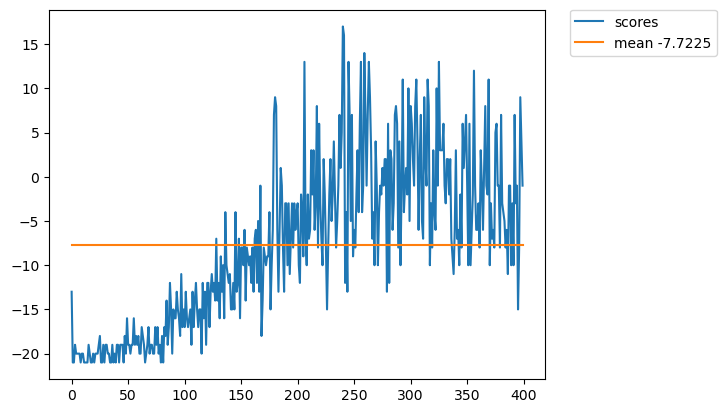

In [10]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams (should be sufficient)
annealing_steps = 100000  # not episodes!
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min) / annealing_steps
alpha = 0.0001
batch_size = 64
memory_size = 10000
start_replay_step = 10000
target_model_update_interval = 1000
train_freq = 4

agent = DQNAgent(action_size=action_size, state_size=state_size, gamma=gamma, 
                 epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
                 alpha=alpha, batch_size=batch_size, memory_size=memory_size,
                 start_replay_step=start_replay_step, 
                 target_model_update_interval=target_model_update_interval, train_freq=train_freq)

statistics = interact_with_environment(env, agent, n_episodes=400, verbose=True)
env.close()
plot_statistics(statistics)

#### Aufbau Keras Model
Der Aufbau des Keras-Modells kann zur Verdeutlichung nochmals geplottet werden.

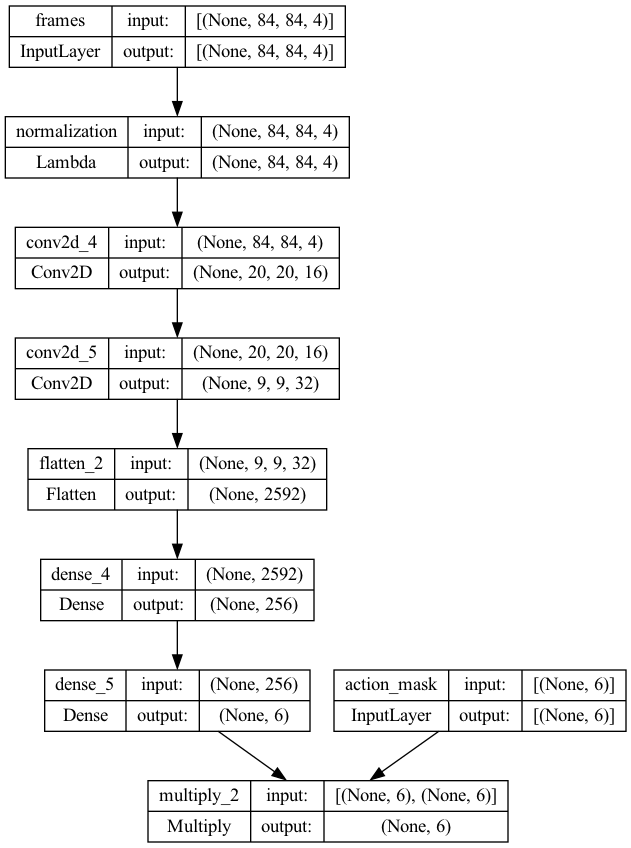

In [11]:
tf.keras.utils.plot_model(agent.model, to_file='keras_plot_model_2.png', show_shapes=True)
display.Image('keras_plot_model_2.png')

#### Save the Model / Agent

In [46]:
import pickle
from os import path

save_dir = "./5_saved_model"

In [54]:

agent.model.save(path.join(save_dir, "model.tf"))
agent.target_model.save(path.join(save_dir, "target_model.tf"))

In [55]:
agent.model = None
agent.target_model = None


In [56]:

with open(path.join(save_dir, "agent.pkl"), "wb") as f:
    pickle.dump(agent, f)
    f.close()

#### Load the agent

In [57]:
with open(path.join(save_dir, "agent.pkl"), "rb") as f:
    agent = pickle.load(f)
    f.close()

agent.model = tf.keras.models.load_model(path.join(save_dir, "model.tf"))
agent.target_model = tf.keras.models.load_model(path.join(save_dir, "target_model.tf"))

#### Performanceauswertung (Video)
Der folgende Code dient zur Performancebewertung des Agenten. Der (hoffentlich) trainierte Agent wird bei seiner Ausführung gefilmt, trainiert aber nicht weiter. Anschließend wird das Video seiner besten Performance dargestellt.

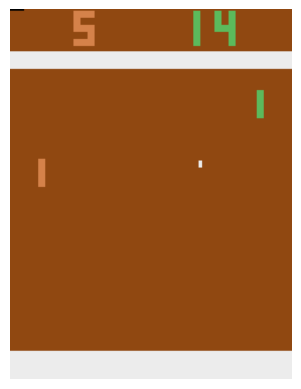

In [58]:
for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### Quiz: DQN

#### Frage 1: Wie könnte man das Lernen weiter optimieren?

Antwort: # TODO

#### Frage 2: Welche Ansätze hat DeepMind verfolgt, um das Lernen weiter zu optimieren?

Antwort: # TODO (**Hinweis**: Double DQN, Dueling und Prioritzed Replay)